# 1.2 - MODIS Reprojection

In [1]:
import autoroot
import os
from pathlib import Path
import earthaccess
from goes2go import GOES # activate the rio accessor
import rioxarray  # activate the rio accessor
import xarray as xr
import pandas as pd
from dataclasses import dataclass
from datetime import datetime, timedelta


# PLOTTING
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# GOES2GO
import goes2go
from rs_tools._src.data.goes.download import goes_download

# GEOREADER
from georeader.dataarray import fromDataArray, toDataArray
from georeader.read import read_reproject, read_reproject_like
from georeader.griddata import read_to_crs, footprint

# RESAMPLE
from pyresample import kd_tree
from pyresample.geometry import SwathDefinition, GridDefinition
import numpy as np

# GEOBOX
from odc.geo.xr import xr_coords
from odc.geo.geom import BoundingBox
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS

from odc.geo.data import ocean_geom, country_geom


from dotenv import load_dotenv

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


In [2]:
import rasterio
from rs_tools.geoprocess import calculate_xrio_footprint
from georeader.window_utils import window_polygon, polygon_to_crs, compare_crs
from georeader.griddata import read_to_crs, footprint as swath_footprint
from georeader import get_utm_epsg
from rs_tools._src.utils.io import get_list_filenames
from rs_tools.modis import regrid_swath_to_regular

In [3]:
# environment variables
username = os.environ['EARTHDATA_USERNAME']
password = os.environ['EARTHDATA_PASSWORD']
save_dir = Path(os.getenv("ITI_DATA_SAVEDIR"))
modis_read_dir_clean = "/pool/usuarios/juanjohn/data/iti/pipeline_test/modis/clean"
modis_save_dir_analysis = "/pool/usuarios/juanjohn/data/iti/pipeline_test/modis/analysis"

In [4]:
# list of all .hdf files in the directory
all_modis_files = get_list_filenames(modis_read_dir_clean, ".nc")

# filter files for terra files ONLY ( our satellite id)
modis_files = list(filter(lambda x: "aqua" in x, all_modis_files))

len(all_modis_files), len(modis_files)

(12, 12)

In [5]:
modis_swath = xr.open_dataset(modis_files[0], engine="netcdf4")

# add some CRS information
modis_swath = modis_swath.rio.write_crs(4326, inplace=True)

modis_swath

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'cumproduct'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 440MB
Dimensions:          (y: 2030, x: 1354, band: 38, time: 1, band_wavelength: 38)
Coordinates:
    latitude         (y, x) float32 11MB ...
    longitude        (y, x) float32 11MB ...
  * band             (band) <U4 608B '1' '10' '11' '12' ... '6' '7' '8' '9'
  * time             (time) <U16 64B '2020-10-01 15:00'
  * band_wavelength  (band_wavelength) float64 304B 0.645 0.8585 ... 13.94 14.23
    spatial_ref      int64 8B 0
Dimensions without coordinates: y, x
Data variables:
    radiance         (band, y, x) float32 418MB ...

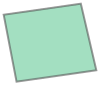

In [6]:
# calculate modis swath polygon
modis_swath_polygon = swath_footprint(modis_swath.longitude.values, modis_swath.latitude.values)

modis_swath_polygon

In [7]:
# footprint??

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


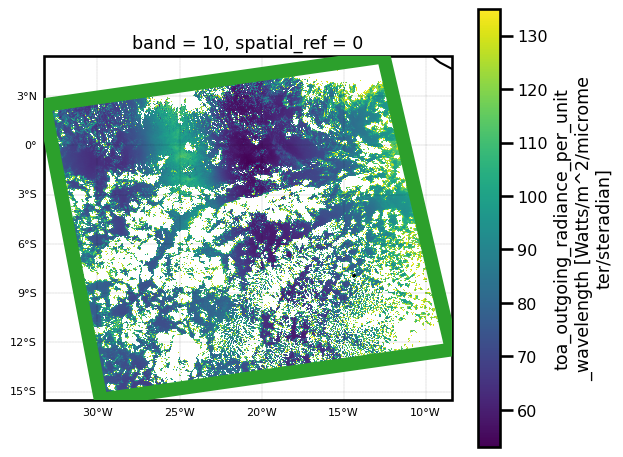

In [8]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

modis_swath.isel(band=1).radiance.plot(
    ax=ax,
    x="longitude", y="latitude", 
    transform=ccrs.PlateCarree(),
)

ax.coastlines()

ax.add_geometries(
    [modis_swath_polygon],
    crs=ccrs.CRS(modis_swath.rio.crs),
    facecolor="none",
    edgecolor="tab:green",
    alpha=1,
    linewidth=10,
    zorder=10,
)


# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

## Reprojection: Regular Grid

The first option is to reproject the data onto a regular grid.
In this case, regular means Lat-Lon but with a constant `dlon,dlat`.
This behaves like an image which makes it easier to work with for tools.

In [9]:


# regrid to regular
resolution = 0.01
calibration = "radiance"
modis_grid = regrid_swath_to_regular(modis_swath, calibration=calibration, resolution=resolution)
modis_grid

<xarray.Dataset> Size: 790MB
Dimensions:          (band: 38, latitude: 2092, longitude: 2485,
                      band_wavelength: 38, time: 1)
Coordinates:
  * band             (band) <U4 608B '1' '10' '11' '12' ... '6' '7' '8' '9'
  * band_wavelength  (band_wavelength) float64 304B 0.645 0.8585 ... 13.94 14.23
  * time             (time) <U16 64B '2020-10-01 15:00'
  * longitude        (longitude) float64 20kB -33.24 -33.23 ... -8.415 -8.405
  * latitude         (latitude) float64 17kB 5.415 5.405 5.395 ... -15.48 -15.49
    spatial_ref      int64 8B 0
Data variables:
    radiance         (band, latitude, longitude) float32 790MB 0.0 0.0 ... 0.0

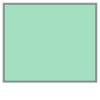

In [10]:
modis_grid_polygon = calculate_xrio_footprint(modis_grid)

modis_grid_polygon

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:790: UserWarning: Approximating coordinate system <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


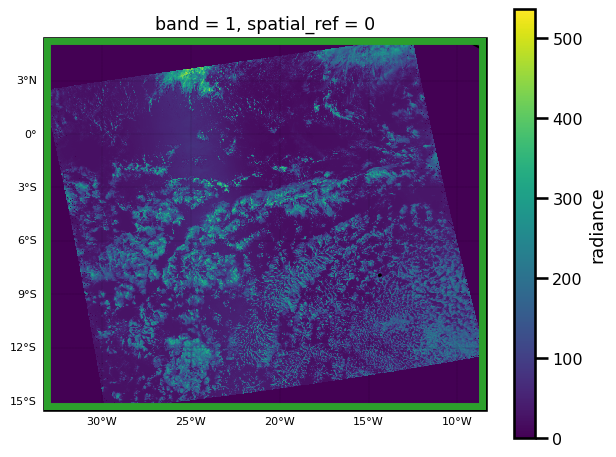

In [11]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

modis_grid.isel(band=0)[calibration].plot(
    ax=ax,
    x="longitude", y="latitude", 
    transform=ccrs.PlateCarree(),
)

ax.add_geometries(
    [modis_grid_polygon],
    crs=ccrs.CRS(modis_grid.rio.crs),
    facecolor="none",
    edgecolor="tab:green",
    alpha=1,
    linewidth=10,
    zorder=10,
)

ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
plt.tight_layout()
plt.show()

In [12]:
# CRS
src_crs = modis_grid.rio.crs
print(f"CRS:\n{src_crs}\n")

# bounds
src_bounds = modis_grid.rio.bounds()
print(f"Bounds:\n{src_bounds}\n")

# resolution
src_resolution = modis_grid.rio.resolution()
print(f"Resolution:\n{src_resolution}\n")

# transformation
src_transform = modis_grid.rio.transform()
print(f"Transform:\n{src_transform}\n")

CRS:
EPSG:4326

Bounds:
(-33.25, -15.499999999999998, -8.399999999999997, 5.420000000000002)

Resolution:
(0.01, -0.01)

Transform:
| 0.01, 0.00,-33.25|
| 0.00,-0.01, 5.42|
| 0.00, 0.00, 1.00|



### Reprojection: UTM

Another option is to reproject to a UTM grid.
This works nicely because it will transform the data into meters instead of degrees which is much easier to manipulate.

In [13]:
# estimate utm
utm_espg = modis_grid.rio.estimate_utm_crs()
print(f"Approximate UTM Projection: {utm_espg}")

Approximate UTM Projection: EPSG:32727


In [14]:
%%time

# reproject to utm
resolution = 1_000 # meters
modis_grid_utm = modis_grid.rio.reproject(utm_espg, resolution=resolution)
modis_grid_utm.rio.shape

CPU times: user 4.2 s, sys: 281 ms, total: 4.48 s
Wall time: 4.52 s


(2369, 2788)

In [15]:
# CRS
src_crs = modis_grid_utm.rio.crs
print(f"CRS:\n{src_crs}\n")

# bounds
src_bounds = modis_grid_utm.rio.bounds()
print(f"Bounds:\n{src_bounds}\n")

# resolution
src_resolution = modis_grid_utm.rio.resolution()
print(f"Resolution:\n{src_resolution}\n")

# transformation
src_transform = modis_grid_utm.rio.transform()
print(f"Transform:\n{src_transform}\n")

CRS:
EPSG:32727

Bounds:
(-873695.1960561767, 8244886.240909902, 1914304.8039438233, 10613886.240909902)

Resolution:
(1000.0, -1000.0)

Transform:
| 1000.00, 0.00,-873695.20|
| 0.00,-1000.00, 10613886.24|
| 0.00, 0.00, 1.00|



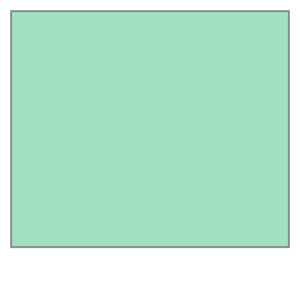

In [16]:
# calculate footprint (polygon)
modis_grid_utm_polygon = calculate_xrio_footprint(modis_grid_utm)
modis_grid_utm_polygon

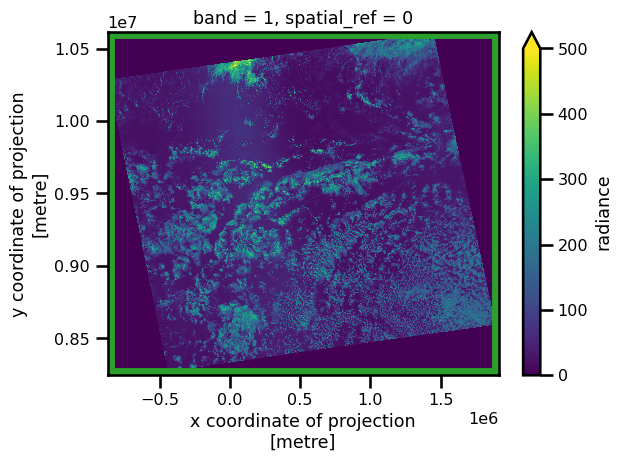

In [17]:
fig, ax = plt.subplots()
modis_grid_utm.isel(band=0)[calibration].plot.imshow(
    ax=ax,
    x="x", y="y", 
    vmax=500
    # transform=modis_grid_utm.rio.transform,
)

polygon_coords = modis_grid_utm_polygon.exterior.xy
ax.plot(*polygon_coords, linewidth=10, color="tab:green")


plt.tight_layout()
plt.show()